In [1]:
import datetime 
import urllib, re, math
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
# change plot size
plt.rcParams['figure.dpi'] = 200
# change max number of rows to show
pd.set_option('display.max_rows', 300)

try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

In [11]:

#!pip install pandas -v
print(version.parse(pd.__version__))


0.23.4


In [12]:
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids
df =df.set_index(["Country/Region","Lat","Long","Province/State"])

dt = df.columns[-1]
print(dt)
if sum(df[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data = df.drop(columns=dt)
else:
    data = df
#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
print(noChin)
data.loc["NoChina",np.NaN,np.NaN,np.NaN]=data.loc[(noChin)].sum()    

# note this is an over-estimate
data.loc[("USAll",np.NaN,np.NaN,np.NaN)]=data.loc["US"].sum()    

data.loc[("ChinaAll",np.NaN,np.NaN,np.NaN)]=data.loc["China"].sum()  

3/12/20
Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       ...
       'Taiwan*', 'Thailand', 'Togo', 'Tunisia', 'Turkey', 'US', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'Vietnam'],
      dtype='object', name='Country/Region', length=115)


In [13]:
# usa has a problem cities and states overlap
usStates="""
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
"""

US = usStates.split('\n')[1:-1]
#data.loc[(US)]
sp.size(US)
#usStates.split('\n')[1:-1]
#US = list(set(data.index.levels[3])&set(US))
print(data.loc[("US",slice(None),slice(None),US)].sum()[-1])
print(data.loc["US"].sum()[-1])
#data.filter(like=',',axis=0)
#data.loc["US"]
#data.loc["US"]
#data.loc[("US",slice(None),slice(None), lambda df.: df.index.levels[3].str.contains(','))]


1586
1663


In [43]:


# create new groups
# dont use string for UR, but the 50 states
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"]
northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Euro":euro,            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


In [46]:

#data.loc["Italy"][dt]
data[dt]# get last row
data[data[dt]>800].sort_values("Country/Region").iloc[:,-5:]

3/8/20  3/9/20  3/10/20  \
Country/Region Lat     Long      Province/State                            
China          30.9756  112.2707 Hubei            67707   67743    67760   
               23.3417  113.4244 Guangdong         1352    1352     1353   
               33.8820  113.6140 Henan             1272    1272     1272   
               29.1832  120.0934 Zhejiang          1215    1215     1215   
               27.6104  111.7088 Hunan             1018    1018     1018   
               31.8257  117.2264 Anhui              990     990      990   
               27.6140  115.7221 Jiangxi            935     935      935   
ChinaAll       NaN     NaN       NaN              80823   80860    80887   
France         46.2276  2.2137   France            1126    1209     1784   
Germany        51.0000  9.0000   NaN               1040    1176     1457   
Iran           32.0000  53.0000  NaN               6566    7161     8042   
Italy          43.0000  12.0000  NaN               7375    9172    10149   
Korea, South   36.0000  128.0000 NaN               7314    7478     7513   
NoChina        NaN     NaN       NaN              28972   32701    37705   
Spain          40.0000 -4.0000   NaN                673    1073     1695   
USAll          NaN     NaN       NaN                518     583      959   

                                                 3/11/20  3/12/20  
Country/Region Lat     Long      Province/State                    
China          30.9756  112.2707 Hubei             67773    67781  
               23.3417  113.4244 Guangdong          1356     1356  
               33.8820  113.6140 Henan              1273     1273  
               29.1832  120.0934 Zhejiang           1215     1215  
               27.6104  111.7088 Hunan              1018     1018  
               31.8257  117.2264 Anhui               990      990  
               27.6140  115.7221 Jiangxi             935      935  
ChinaAll       NaN     NaN       NaN               80921    80932  
France         46.2276  2.2137   France             2281     2281  
Germany        51.0000  9.0000   NaN                1908     2078  
Iran           32.0000  53.0000  NaN                9000    10075  
Italy          43.0000  12.0000  NaN               12462    12462  
Korea, South   36.0000  128.0000 NaN                7755     7869  
NoChina        NaN     NaN       NaN               44944    47411  
Spain          40.0000 -4.0000   NaN                2277     2277  
USAll          NaN     NaN       NaN                1281     1663

In [59]:
#assume (1+E*P) is 120%
import matplotlib.ticker as mticker

myLocator = mticker.MultipleLocator(7)

#determine slope and plot
for name in ["NoChina","China"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].grid()
    fig.autofmt_xdate()
    
    #---
    ax[0].plot(data.loc[ctr].sum())        
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].grid()
    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


NameError: name 'countries' is not defined

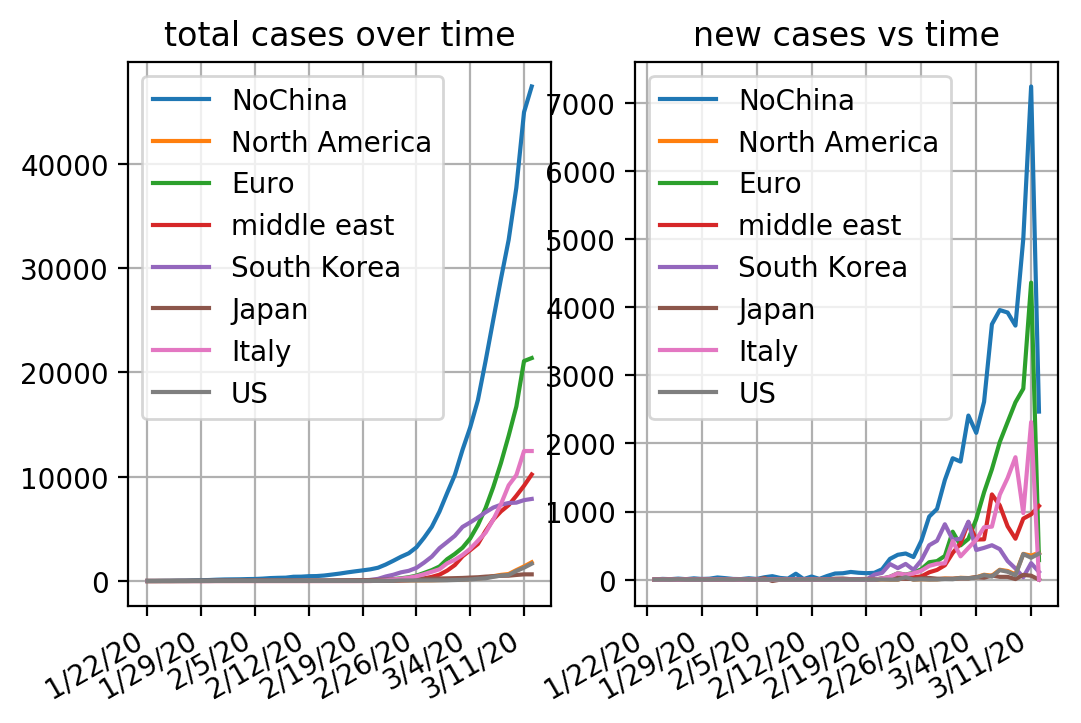

In [44]:
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    ax[0].plot(data.loc[(country)].sum(),label=name)
ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals,label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
fig.autofmt_xdate()

ax[1].legend()
ax[1].set_title("new cases vs time");

In [ ]:
#raw data
data.loc["US"].sum()

# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

[ The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far. ]


A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


48
50


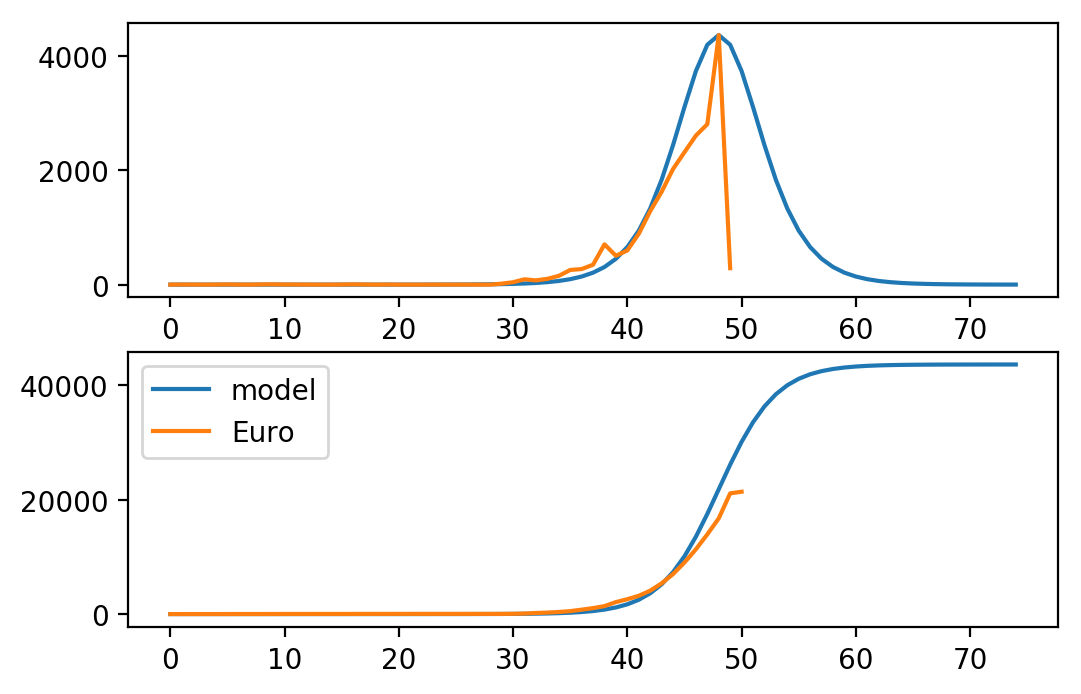

In [45]:

filtV= "South Korea"
#filtV= "China"

#filtV = "Italy"
filtV = "Euro"
for ctr in countries.keys():
    
    if not filtV == ctr: continue
    
        
    Nd = data.loc[countries[ctr]].sum().diff().values[1:]
    
    A=max(Nd)
    B=0.2

    C=np.argmax(Nd)

    # must be in days
    print(C)
    print(sp.size(Nd))
    t = np.arange(0,sp.size(Nd)+25)
    fig, ax = plt.subplots(2,1,)
    ax[0].plot(A/(np.cosh( B * (t-C))**2),label="model")
    ax[0].plot(Nd,label=ctr)
    ax[1].grid()
    ax[1].plot(A/B * ( np.tanh( B * (t-C)) + 1 ),label="model")
    ax[1].plot(data.loc[countries[ctr]].sum().values,label=ctr)
    ax[1].grid()
    plt.legend()
    #plt.title("total cases over time");


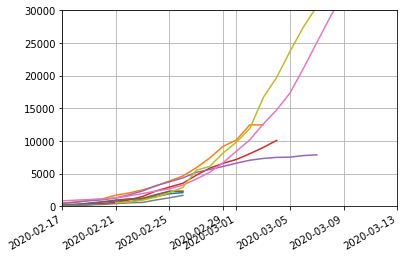

In [9]:
offsets = {"ChinaAll":30,
           "Italy":-9,
           "Spain":-15,
           "Iran":-8,
           "Germany":-15,
           "Korea, South":-5,
           "France":-15,
           "NoChina":0,
           "USAll":-15}
fig, ax=plt.subplots(1,1)
for index, row in data[data[dt]>1000].iterrows():
    ctr =index[0]
    #print(ctr)
    if("China" == ctr): continue
    #if np.isnan(index[3]):
    #    name = "%s%s"%(index[0],"")
#    else:
 #       name = "%s%s"%(index[0],index[3])
  #  print(name)
    #print(row.sum())
    
    vdt = [(datetime.datetime.strptime(d,"%m/%d/%y") +datetime.timedelta(days=offsets[ctr])).date()#.strftime("%m/%d")
           for d in data.columns]
    
    
    #print(vdt)
    #print(sp.size(vdt))
    #print(sp.size(row.values))
    ax.plot(vdt,row.values, label=ctr)
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.set_ylim(0, 30000)
#ax.set_xlim("2/4","3/10")
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today())

fig.autofmt_xdate()



1619.8305690912039

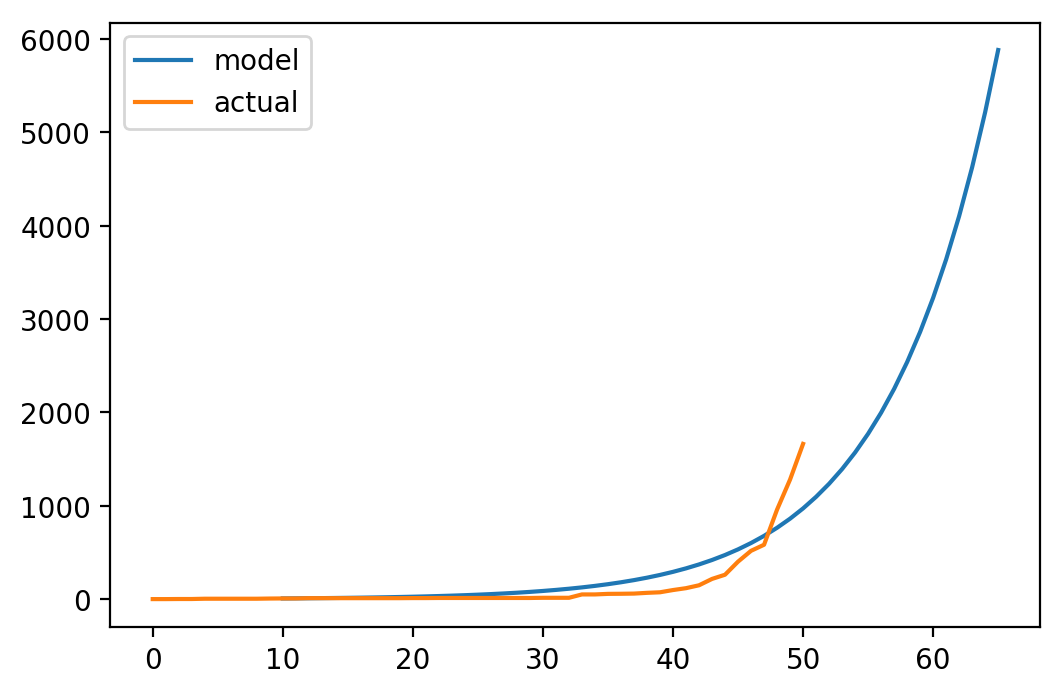

In [158]:
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .12
startDate ="2/1/20"
ctr       = "US"
TN        = 15     # number of intervals after today
N  = sp.size(data.columns)
Y0 = data[startDate][ctr].sum()
offset = [i for i in range(0,sp.size(data.columns)) if data.columns[i] ==startDate][0]
Yt =Y0 * sp.exp(rate * np.arange(0,N-offset + TN))




plt.plot(np.arange(offset,N+TN),Yt,label="model")
plt.plot(data.loc[ctr].sum().values,label="actual")
plt.legend()

# using a growth rate of of 10%, assuming we are better then NoChina:1.14, given outlier of iran/italy
#today us has 1200, by monday we will have
1200 * np.exp(.1 * 3)

{'02/15/20': 165.0,
 '02/16/20': 186.036980510597,
 '02/17/20': 209.7561098030318,
 '02/18/20': 236.4993534024561,
 '02/19/20': 266.65227636182743,
 '02/20/20': 300.64960206443396,
 '02/21/20': 338.98147975624147,
 '02/22/20': 382.2005511688801,
 '02/23/20': 430.9299181148144,
 '02/24/20': 485.8721259258115,
 '02/25/20': 547.8192922515303,
 '02/26/20': 617.6645272480422,
 '02/27/20': 696.4148098044311,
 '02/28/20': 785.205505447746,
 '02/29/20': 885.3167352351257,
 '03/01/20': 998.1918316281359,
 '03/02/20': 1125.4581474329736,
 '03/03/20': 1268.9505178150346,
 '03/04/20': 1430.7377136464702,
 '03/05/20': 1613.1522675722692,
 '03/06/20': 1818.8241028058642,
 '03/07/20': 2050.718449490295,
 '03/08/20': 2312.178595276045,
 '03/09/20': 2606.9740864629653,
 '03/10/20': 2939.3550746360124,
 '03/11/20': 3314.1135923259653,
 '03/12/20': 3736.6526411239406,
 '03/13/20': 4213.064088313,
 '03/14/20': 4750.216495075041,
 '03/15/20': 5355.854142517526,
 '03/16/20': 6038.708683206865,
 '03/17/20': 

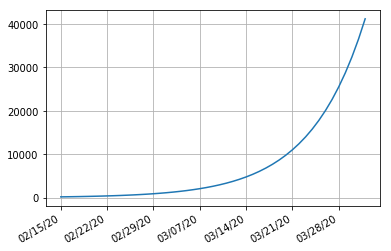

In [66]:
#using cdc data direclty
v = [int(t) for t in "0	0	2	0	1	0	0	0	1	1	1	0	1	3	0	0	2	1	1	0	1	1	0	0	0	1	0	1	0	3	1	1	3	2	0	0	5	10	6	7	11	14	13	34	16	30	19	40	40	53	51	48	58	74	43	79	46	50	15	2	0".split("\t")]
#but last week has been under report, so drop those samples
startDate = datetime.datetime(2020,2,15)

ss=36
ee=-8
y = np.add.accumulate(v)[ss:ee]
v = v[ss:ee]
today    = datetime.datetime.today()
N  = (today-startDate).days
#project for another 2 week
NP = 20
#start from scratch take y[0] and assume 10% groth and assume, y0 was 20% reported
yh = y[0] * 5 * np.exp(.12 * np.arange(0,N+NP))
x = [(startDate+datetime.timedelta(days=int(i))).strftime("%m/%d/%y") for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)
plt.plot(x,yh)
ax.xaxis.set_major_locator(myLocator)
ax.grid()
fig.autofmt_xdate()
dict(zip(x,yh))
